# Import libraries

In [1]:
import numpy as np
import pandas as pd

# Load data

In [3]:
encoded_applications = pd.read_csv("../Dataset/processed_applications.csv")
credits = pd.read_csv("../Dataset/scores.csv")

# Adjust Data
Splitting data for Semi-supervised learning

In [18]:
updated_applicants = pd.merge(encoded_applications, credits, on='id', how='left')
updated_applicants = updated_applicants.drop(['id'], axis=1)

In [19]:
applicants_w_records = updated_applicants.dropna(subset = ["total_score"])
applicants_no_records = updated_applicants.loc[updated_applicants["total_score"].isna()]


We split away around 20% of the applicants with records as test data.

In [20]:
removal_index_labeled = range(0, len(applicants_w_records), 5)
test_data = applicants_w_records.reset_index().filter(removal_index_labeled, axis=0)
train_data = applicants_w_records.reset_index().drop(removal_index_labeled, axis=0)

In [21]:
x_test_data = test_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
y_test_data = test_data['total_score'].to_numpy(dtype=float)
x_train_data = train_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
y_train_data = train_data['total_score'].to_numpy(dtype=float)

We split the unlabelled data into 3 sets.

In [22]:
removal_index_unlabelled1 = range(0, len(applicants_no_records), 3)
removal_index_unlabelled2 = range(1, len(applicants_no_records), 3)
removal_index_unlabelled3 = range(2, len(applicants_no_records), 3)
unlabelled_data_1 = applicants_no_records.reset_index().filter(removal_index_unlabelled1, axis=0)
unlabelled_data_2 = applicants_no_records.reset_index().filter(removal_index_unlabelled2, axis=0)
unlabelled_data_3 = applicants_no_records.reset_index().filter(removal_index_unlabelled3, axis=0)

x_unlabelled_data_1 = unlabelled_data_1.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
x_unlabelled_data_2 = unlabelled_data_2.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
x_unlabelled_data_3 = unlabelled_data_3.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)

We remove first column as they are indexes.

In [23]:
x_test_data = np.delete(x_test_data, 0, axis=1)
x_train_data = np.delete(x_train_data, 0, axis=1)
x_unlabelled_data_1 = np.delete(x_unlabelled_data_1, 0, axis=1)
x_unlabelled_data_2 = np.delete(x_unlabelled_data_2, 0, axis=1)
x_unlabelled_data_3 = np.delete(x_unlabelled_data_3, 0, axis=1)

# Semi-supervised Learning
We will now use the learning model to implement linear regression

Datasets:
* x_test_data
* y_test_data
* x_train_data
* y_train_data
* x_unlabelled_data_1
* x_unlabelled_data_2
* x_unlabelled_data_3

# Linear Regression

We train our first set of linear regression model.

In [24]:
from sklearn.linear_model import LinearRegression
lin_model_one = LinearRegression()
lin_model_one.fit(x_train_data, y_train_data)

LinearRegression()

First set of pseudo-labels for linear regression.

In [25]:
linreg_labels_1 = lin_model_one.predict(x_unlabelled_data_1)

Filter out confident pseudo-labels and add into current set of labelled data.

In [26]:
new_x_train_data_linreg = np.vstack((x_train_data, x_unlabelled_data_1))
new_y_train_data_linreg = np.append(y_train_data, linreg_labels_1)

### Second Linear Regression Training

In [27]:
lin_model_two = LinearRegression()
lin_model_two.fit(new_x_train_data_linreg, new_y_train_data_linreg)
linreg_labels_2 = lin_model_two.predict(x_unlabelled_data_2)

Adjustment to training data.

In [28]:
new_x_train_data_linreg = np.vstack((new_x_train_data_linreg, x_unlabelled_data_2))
new_y_train_data_linreg = np.append(new_y_train_data_linreg, linreg_labels_2)

### Third training

In [29]:
lin_model_three = LinearRegression()
lin_model_three.fit(new_x_train_data_linreg, new_y_train_data_linreg)
linreg_labels_3 = lin_model_three.predict(x_unlabelled_data_3)

Adjustment to training data.

In [30]:
new_x_train_data_linreg = np.vstack((new_x_train_data_linreg, x_unlabelled_data_3))
new_y_train_data_linreg = np.append(new_y_train_data_linreg, linreg_labels_3)

### Fourth training

In [31]:
lin_model_four = LinearRegression()
lin_model_four.fit(new_x_train_data_linreg, new_y_train_data_linreg)

LinearRegression()

### Testing accuracy of linear model
We will now test the accuracy of our linear model.

In [32]:
from sklearn.metrics import mean_squared_error

test_accuracy = lin_model_four.predict(x_test_data)
mean_squared_error(y_test_data, test_accuracy)

0.010410975908442248

# How about simply using labelled data?

In [33]:
labelled_data_accuracy = lin_model_one.predict(x_test_data)
mean_squared_error(y_test_data, labelled_data_accuracy)

0.010410975908442205

# Comparison on MSE changes per training: LinearReg vs Neural Network

(0.0095, 0.0105)

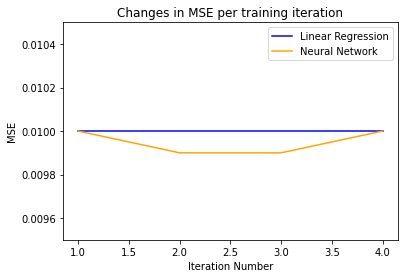

In [34]:
MSE_per_training = []

# Manually extracted from NN modelling.
MSE_for_NN = [0.01, 0.0099, 0.0099, 0.01]

test_accuracy_1 = lin_model_one.predict(x_test_data)
test_accuracy_2 = lin_model_two.predict(x_test_data)
test_accuracy_3 = lin_model_three.predict(x_test_data)
test_accuracy_4 = lin_model_four.predict(x_test_data)

MSE_per_training.append(round(mean_squared_error(y_test_data, test_accuracy_1), 2))
MSE_per_training.append(round(mean_squared_error(y_test_data, test_accuracy_2), 2))
MSE_per_training.append(round(mean_squared_error(y_test_data, test_accuracy_3), 2))
MSE_per_training.append(round(mean_squared_error(y_test_data, test_accuracy_4), 2))

import matplotlib.pyplot as plt

plt.plot([1,2,3,4], MSE_per_training, label="Linear Regression", color = "blue")
plt.plot([1,2,3,4], MSE_for_NN, label="Neural Network", color = "orange")

plt.title("Changes in MSE per training iteration")
plt.xlabel("Iteration Number")
plt.ylabel("MSE")
plt.legend()
plt.ylim(0.0095, 0.0105)